In [1]:
#%load_ext autoreload
#%autoreload 2
from __future__ import division, print_function
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

import emcee
import batman
import corner
import kplr

import OoT.oot as oot
import scipy.misc as sMisc
from astropy.stats import LombScargle
import astropy.io
import pylanet.data as pydata
import pylanet.model as pymodel
import pylanet.plot as pyplot
import astropy.units as u

%matplotlib inline

In [2]:
plt.style.use('ggplot')
mpl.rcParams['lines.linewidth'] = 3
mpl.rcParams['axes.facecolor']='white'
mpl.rcParams['axes.edgecolor']='k'
mpl.rcParams['axes.linewidth']=3
mpl.rcParams['font.size']=16
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['text.color'] = 'k'
#mpl.rcParams['xtick.major.width'] = 2
#mpl.rcParams['ytick.major.width'] = 2
mpl.rcParams['xtick.major.size'] = 3.6
mpl.rcParams['ytick.major.size'] = 3.6
mpl.rcParams['xtick.color']='k'
mpl.rcParams['ytick.color']='k'
mpl.rcParams['axes.labelcolor']='k'

mpl.rcParams['xtick.direction']='in'
mpl.rcParams['ytick.direction']='in'

## Injection/recovery test: inject a known signal with added noise; de-trend with double box and/or castle; phase fold; look at what we get.

1. Noiseless signal
2. Signal with added gaussian noise
3. Signal with added correlated noise (to mimic stellar activity)
4. Signal with added flares
5. Signal with all of the above

In [3]:
def get_phases(t,P,t0):
    """ 
    Given input times, a period (or posterior dist of periods)
    and time of transit center (or posterior), returns the 
    phase at each time t.
    """
    if type(t) is not float:
        phase = ((t - np.median(t0))/np.median(P)) % 1 
        ii = np.where(phase>=0.5)[0]
        phase[ii] = phase[ii]-1.0
    else:
        phase = ((t - np.median(t0))/np.median(P)) % 1 
        if phase>=0.5:
            phase = phase - 1.0 
    return phase

# case 1: noiseless

2447


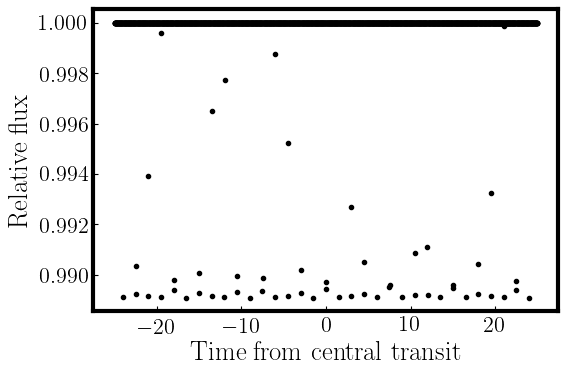

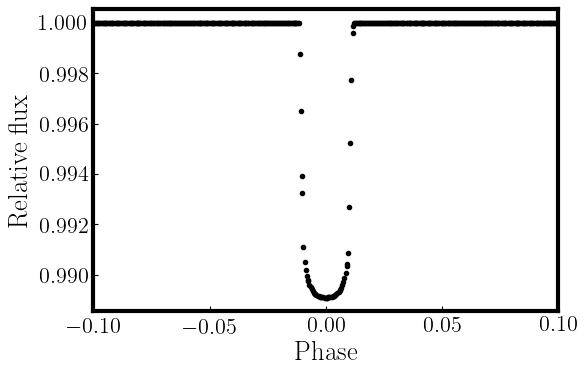

In [4]:
params = batman.TransitParams()
params.t0 = 0.                       #time of inferior conjunction
params.per = 1.5                      #orbital period
params.rp = 0.1                      #planet radius (in units of stellar radii)
params.a = 15.                       #semi-major axis (in units of stellar radii)
params.inc = 90.                    #orbital inclination (in degrees)
params.ecc = 0.                      #eccentricity
params.w = 90.                       #longitude of periastron (in degrees)
params.u = [0.1, 0.3]                #limb darkening coefficients [u1, u2]
params.limb_dark = "quadratic"       #limb darkening model

texp = 0.020434

t = np.arange(-25., 25., texp)

print(len(t))

m = batman.TransitModel(params, t)    #initializes model
noiselessFlux = m.light_curve(params)          #calculates light curve


plt.plot(t, noiselessFlux, 'k.')
plt.xlabel("Time from central transit")
plt.ylabel("Relative flux")
plt.show()

p = get_phases(t, 1.5, 0.)

plt.plot(p, noiselessFlux, 'k.')
plt.xlim(-0.1,0.1)
plt.xlabel("Phase")
plt.ylabel("Relative flux")
plt.show()

# case 2: Gaussian noise

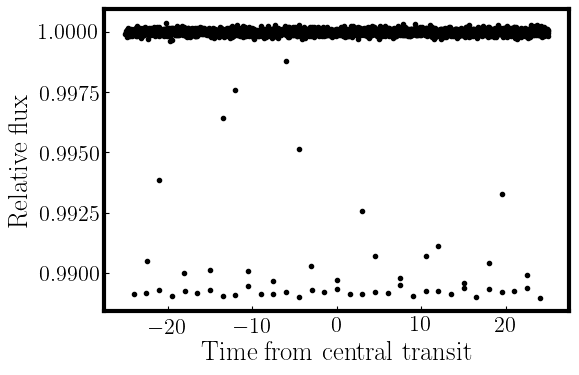

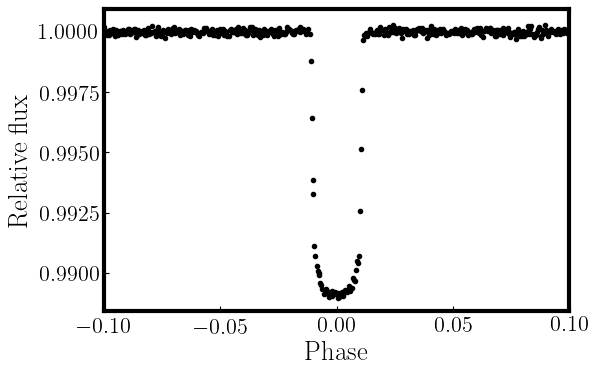

In [5]:
sigma = 1.e-4
err = np.random.normal(loc=0.0,scale=sigma,size=len(noiselessFlux))

gaussianFlux = noiselessFlux + err

plt.plot(t, gaussianFlux, 'k.')
#plt.xlim(-0.1,0.1)
plt.xlabel("Time from central transit")
plt.ylabel("Relative flux")
plt.show()

plt.plot(p, gaussianFlux, 'k.')
plt.xlim(-0.1,0.1)
plt.xlabel("Phase")
plt.ylabel("Relative flux")
plt.show()

# case 3: correlated noise

In [8]:
# non-planet-host with interesting stellar activity and a weird instrumental: kepid 3223374

client = kplr.API()
star = client.star(3223374)

lcs = star.get_light_curves(short_cadence=True)

# Loop over the datasets and read in the data.
time, flux, ferr, quality = [], [], [], []
for lc in lcs:
    with lc.open() as f:
        # The lightcurve data are in the first FITS HDU.
        hdu_data = f[1].data
        time.append(hdu_data["time"])
        flux.append(hdu_data["pdcsap_flux"])
        ferr.append(hdu_data["pdcsap_flux_err"])
        quality.append(hdu_data["sap_quality"])
        

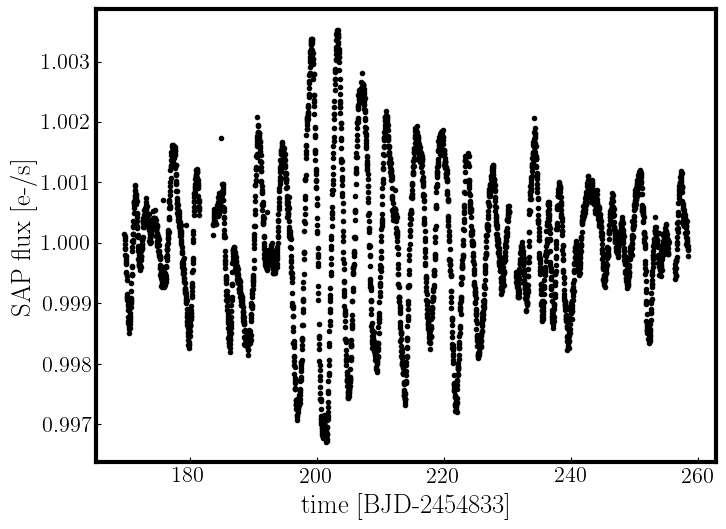

In [9]:
fig = plt.figure(figsize=(8,6))
#for i in range(len(lcs)):
    #print(len(flux[i]))
#    plt.plot(time[i],flux[i])
plt.plot(time[2][~np.isnan(flux[2])],flux[2][~np.isnan(flux[2])]/np.median(flux[2][~np.isnan(flux[2])]),'k.')
plt.xlabel("time [BJD-2454833]")
plt.ylabel("SAP flux [e-/s]")
plt.show()

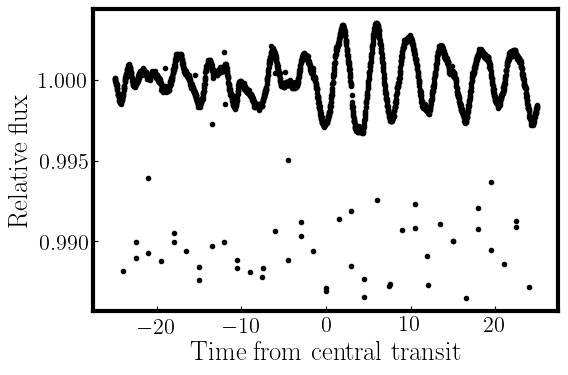

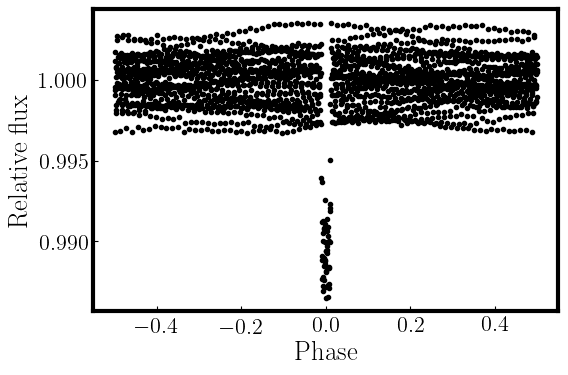

In [10]:
#len(flux[2]) = 4354; meanwhile len(t) = 2447, so plenty of data points.

correlatedNoise = flux[2][~np.isnan(flux[2])]
correlatedNoise = correlatedNoise[0:len(t)]
correlatedNoise = correlatedNoise/np.median(correlatedNoise)

correlatedFlux = noiselessFlux*correlatedNoise

#re-normalize
correlatedFlux = correlatedFlux/np.median(correlatedFlux)

plt.plot(t, correlatedFlux, 'k.')
plt.xlabel("Time from central transit")
plt.ylabel("Relative flux")
plt.show()

plt.plot(p, correlatedFlux, 'k.')
#plt.xlim(-0.1,0.1)
plt.xlabel("Phase")
plt.ylabel("Relative flux")
plt.show()

# Now: detrend and fit with pylanet. (Comment in/out various cases here)

In [11]:
period=1.5
rawTs=t

#rawFs=noiselessFlux
#rawEs=np.zeros_like(noiselessFlux)

#rawFs = gaussianFlux
#rawEs = sigma*np.ones_like(gaussianFlux)

rawFs = correlatedFlux
rawEs = sigma*np.ones_like(gaussianFlux)

In [12]:
#detrend
cTs,cFs,cEs=pydata.cleanData(rawTs,rawFs,rawEs,period,nMin=512,detrendMethod='box')
print(cTs.size,' data points')

2375  data points


In [13]:
#phase-fold
ts,fs,es=pydata.stackData(cTs,cFs,cEs,period,nTs=128)

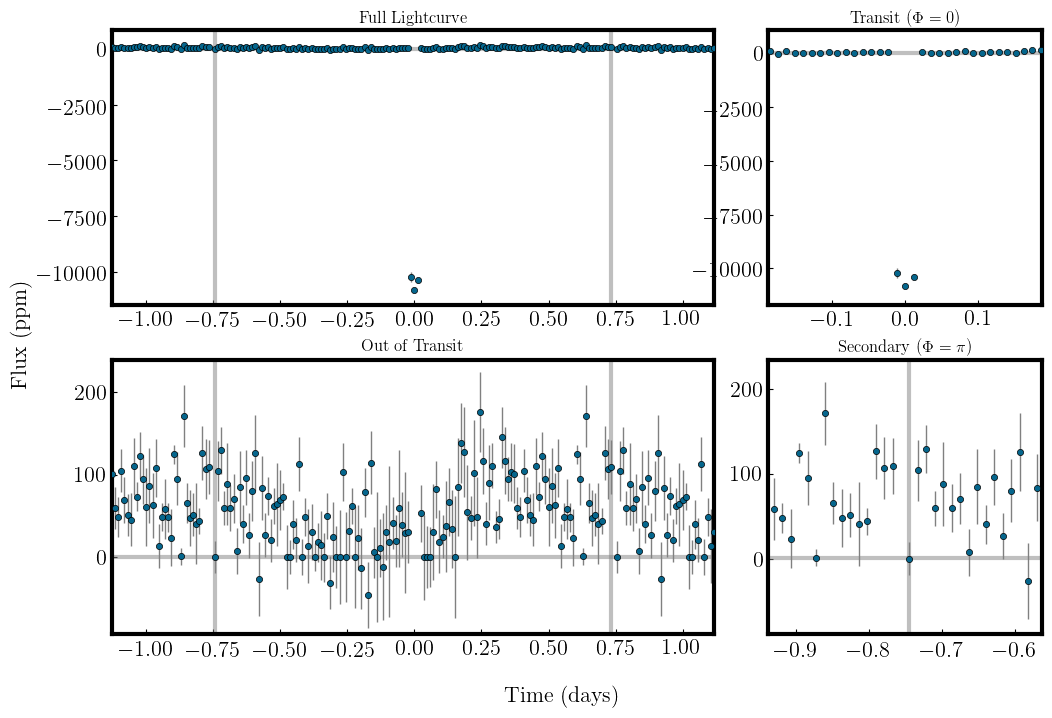

In [14]:
#plot
thisFig,thisGrid=pyplot.makeFig()
pyplot.plotData(thisGrid,ts,fs,es,period=period)

In [15]:
#Create OoT planet object and assign parameters according to NEA values.
planet=oot.planet()
planet.M=1.56
planet.R=2.0
planet.Mp=0.002
planet.Rp=0.155

planet.e=0.006
planet.Ag=0.2
planet.a=planet.a*np.power(period/oot.findPeriod(planet),2./3.)
print('a: ',planet.a)
tTransit=0.
planet.vPhi=np.pi/2. - (np.pi/180.)*204.
planet.vTheta=83.*np.pi/180.
planet.tp=planet.tp+(tTransit-oot.findTransit(planet))

nTs=600
modelTs=np.linspace(-period/2.,period/2.,nTs)
modelFs=1+oot.deltaSum(modelTs,planet)

transit=1
if transit==1:
    t0,per,rp,a,inc,ecc,w=oot.batman(planet)
    params = batman.TransitParams()
    params.t0 = t0                       #time of inferior conjunction
    params.per = per                      #orbital period
    params.rp = rp                     #planet radius (in units of stellar radii)
    params.a = a                       #semi-major axis (in units of stellar radii)
    params.inc = inc                     #orbital inclination (in degrees)
    params.ecc = ecc                      #eccentricity
    params.w = w                       #longitude of periastron (in degrees)
    params.u = [0.6]                #limb darkening coefficients
    params.limb_dark = "linear"       #limb darkening model

    m = batman.TransitModel(params, modelTs)
    batmanModel=m.light_curve(params)
    modelFs=modelFs*batmanModel

norm=np.median(modelFs)
modelFs=(modelFs/norm)-1 + 1.2e-05 #add flux offset to make them line up better
#fs=deltas-np.max(deltas)
modelEs=0.1*np.ones_like(modelFs)*np.median(np.abs(modelFs))


a:  6.398232842598073


/Users/Emily/Documents/Columbia/heartbeatPlanets/OoT/oot.py:142: RuntimeWarning: invalid value encountered in arccos
  firstTerm=((rUnit*pl.Rp)**2)*np.arccos((d**2 + (rUnit*pl.Rp)**2 - pl.R**2)/(2*d*(rUnit*pl.Rp)))
/Users/Emily/Documents/Columbia/heartbeatPlanets/OoT/oot.py:143: RuntimeWarning: invalid value encountered in arccos
  secondTerm=(pl.R**2)*np.arccos((d**2 + pl.R**2 - (rUnit*pl.Rp)**2)/(2*d*pl.R))
/Users/Emily/Documents/Columbia/heartbeatPlanets/OoT/oot.py:144: RuntimeWarning: invalid value encountered in sqrt
  thirdTerm=-0.5*np.sqrt((d+(rUnit*pl.Rp)+pl.R)*(d+(rUnit*pl.Rp)-pl.R)*(d+pl.R-(rUnit*pl.Rp))*(-d+pl.R+(rUnit*pl.Rp)))


/Users/Emily/anaconda2/lib/python2.7/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


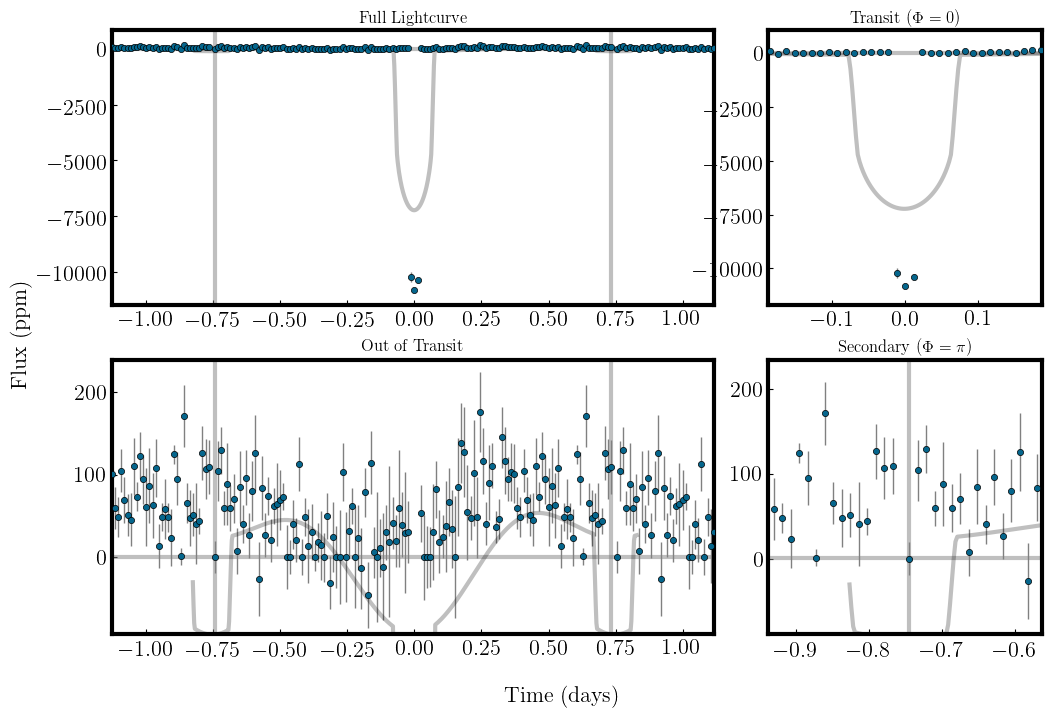

In [16]:
thisFig,thisGrid=pyplot.makeFig()
pyplot.plotData(thisGrid,ts,fs,es,period=period)
pyplot.plotModel(thisGrid,modelTs,modelFs,period=period)

In [17]:
from scipy.stats import norm,beta,truncnorm
def transform_uniform(x,a,b):
    return a + (b-a)*x

def transform_loguniform(x,a,b):
    la=np.log(a)
    lb=np.log(b)
    return np.exp(la + x*(lb-la))

def transform_normal(x,mu,sigma):
    return norm.ppf(x,loc=mu,scale=sigma)

def transform_beta(x,a,b):
    return beta.ppf(x,a,b)

def transform_truncated_normal(x,mu,sigma,a=0.,b=1.):
    ar, br = (a - mu) / sigma, (b - mu) / sigma
    return truncnorm.ppf(x,ar,br,loc=mu,scale=sigma)


## Fit light curve alone

In [18]:
# "walking" parameters:
#    0 = np.log10(Mstar [Msun])
#    1 = np.log10(Mplanet [Msun])
#    2 = np.log10(Rstar [Rsun])
#    3 = np.log10(Rplanet [Rsun])
#    4 = np.log10(ecc)
#    5 = Ag
#    6 = t0 [transit midpoint time, centered at 0 days]
#    7 = b
#    8 = vPhi = pi/2 - omega
#    9 = fractional flux offset

# convert "walking" params to OoT params
def translateParams(planet,x):
    planet.M=10**x[0]
    planet.Mp=10**x[1]
    planet.R=10**x[2]
    planet.Rp=10**x[3]
    planet.e=10**x[4]
    planet.Ag=x[5]
    tTransit=x[6]
    #planet.tp=tTransit-oot.findTransit(planet)
    planet.a=planet.a*np.power(period/oot.findPeriod(planet),2/3) # For a known period, a is a dependant variable
    
    b=x[7]
    planet.vTheta=np.arccos(b*planet.R/planet.a)
    planet.vPhi=x[8]
    
    planet.tp=planet.tp+(tTransit-oot.findTransit(planet))
    
    return planet

def mapXs(x, period): 
    """
    maps 0->1 to appropriate parameter values
    """
    newX=np.copy(x)
    if len(newX.shape)==1:
        newX=newX[np.newaxis,:]
        
    newX[:,0] = transform_uniform(newX[:,0], -1., 1.)       #log10(Mstar)
    newX[:,1] = transform_uniform(newX[:,1], -3.5, -0.5)    #log10(Mplanet)
    newX[:,2] = transform_uniform(newX[:,2], -1.5, 1.5)     #log10(Rstar)
    newX[:,3] = transform_uniform(newX[:,3], -2., 0.)       #log10(Rplanet)
    newX[:,4] = transform_uniform(newX[:,4], -3., 0.)       #log10(ecc)
    newX[:,5] = transform_uniform(newX[:,5], 0., 0.5)       #Ag
    newX[:,6] = transform_uniform(newX[:,6], -0.5*period, 0.5*period)  #t0, centered at 0 days
    #newX[:,7] = transform_uniform(newX[:,7], 0., 1.)       #impact parameter b, no transformation necessary
    newX[:,8] = transform_uniform(newX[:,8], 0., 2.*np.pi)  #vPhi
    newX[:,9] = transform_uniform(newX[:,9], -1.e-4, 1.e-4) #flux offset
    
    if len(x.shape)==1:
        return newX[0,:]
    return newX

def priors(x):
    """
    if we wander outside the unit cube, return -np.inf
    """
    if (np.min(x)<0.) | (np.max(x)>1.):
        return -np.inf
    else:
        return 0.0
    
def lnprobLC(x,period,ts,fs,es,planet):
    """The log-likelihood function."""
    
    prior=priors(x) # ensure all x between 0 and 1
    if not np.isfinite(prior):
        return prior
    
    x=mapXs(x,period) # maps them to appropriate parameter values
    planet=translateParams(planet,x)
    if (planet.R<planet.Rp) | (planet.R>planet.a):
        return -np.inf #at the moment oot breaks if R<Rp - should investigate
    
    ootFs=1.+oot.deltaSum(ts,planet,secondary=1)
    
    transit=oot.checkTransit(planet)
    if transit==1:
        t0,per,rp,a,inc,ecc,w=oot.batman(planet)
        params = batman.TransitParams()
        params.t0 = t0                       #time of inferior conjunction
        params.per = per                      #orbital period
        params.rp = rp                     #planet radius (in units of stellar radii)
        params.a = a                       #semi-major axis (in units of stellar radii)
        params.inc = inc                     #orbital inclination (in degrees)
        params.ecc = ecc                      #eccentricity
        params.w = w                       #longitude of periastron (in degrees)
        params.u = [0.6]                #limb darkening coefficients
        params.limb_dark = "linear"       #limb darkening model

        m = batman.TransitModel(params, ts)
        batmanModel=m.light_curve(params)
        modelFs=ootFs*batmanModel
    else:
        modelFs=ootFs
    
    norm=np.median(modelFs)
    deltas=(modelFs/norm)-1
    deltas=deltas+x[9]     #add fractional flux offset term
    
    residual=np.power((deltas-fs)/es,2)
    return -0.5*np.sum(residual)/2 + prior

ndim, nwalkers = 10, 128
p0=np.random.rand(ndim * nwalkers).reshape((nwalkers, ndim))

nSteps = 2048
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprobLC,args=[period,ts,fs,es,planet])
pos, prob, state=sampler.run_mcmc(p0,nSteps)

/Users/Emily/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:26: RuntimeWarning: invalid value encountered in arccos
/Users/Emily/anaconda2/lib/python2.7/site-packages/emcee/ensemble.py:335: RuntimeWarning: invalid value encountered in subtract
  lnpdiff = (self.dim - 1.) * np.log(zz) + newlnprob - lnprob0
/Users/Emily/anaconda2/lib/python2.7/site-packages/emcee/ensemble.py:336: RuntimeWarning: invalid value encountered in greater
  accept = (lnpdiff > np.log(self._random.rand(len(lnpdiff))))


(128, 2048, 10)
(70144, 10)


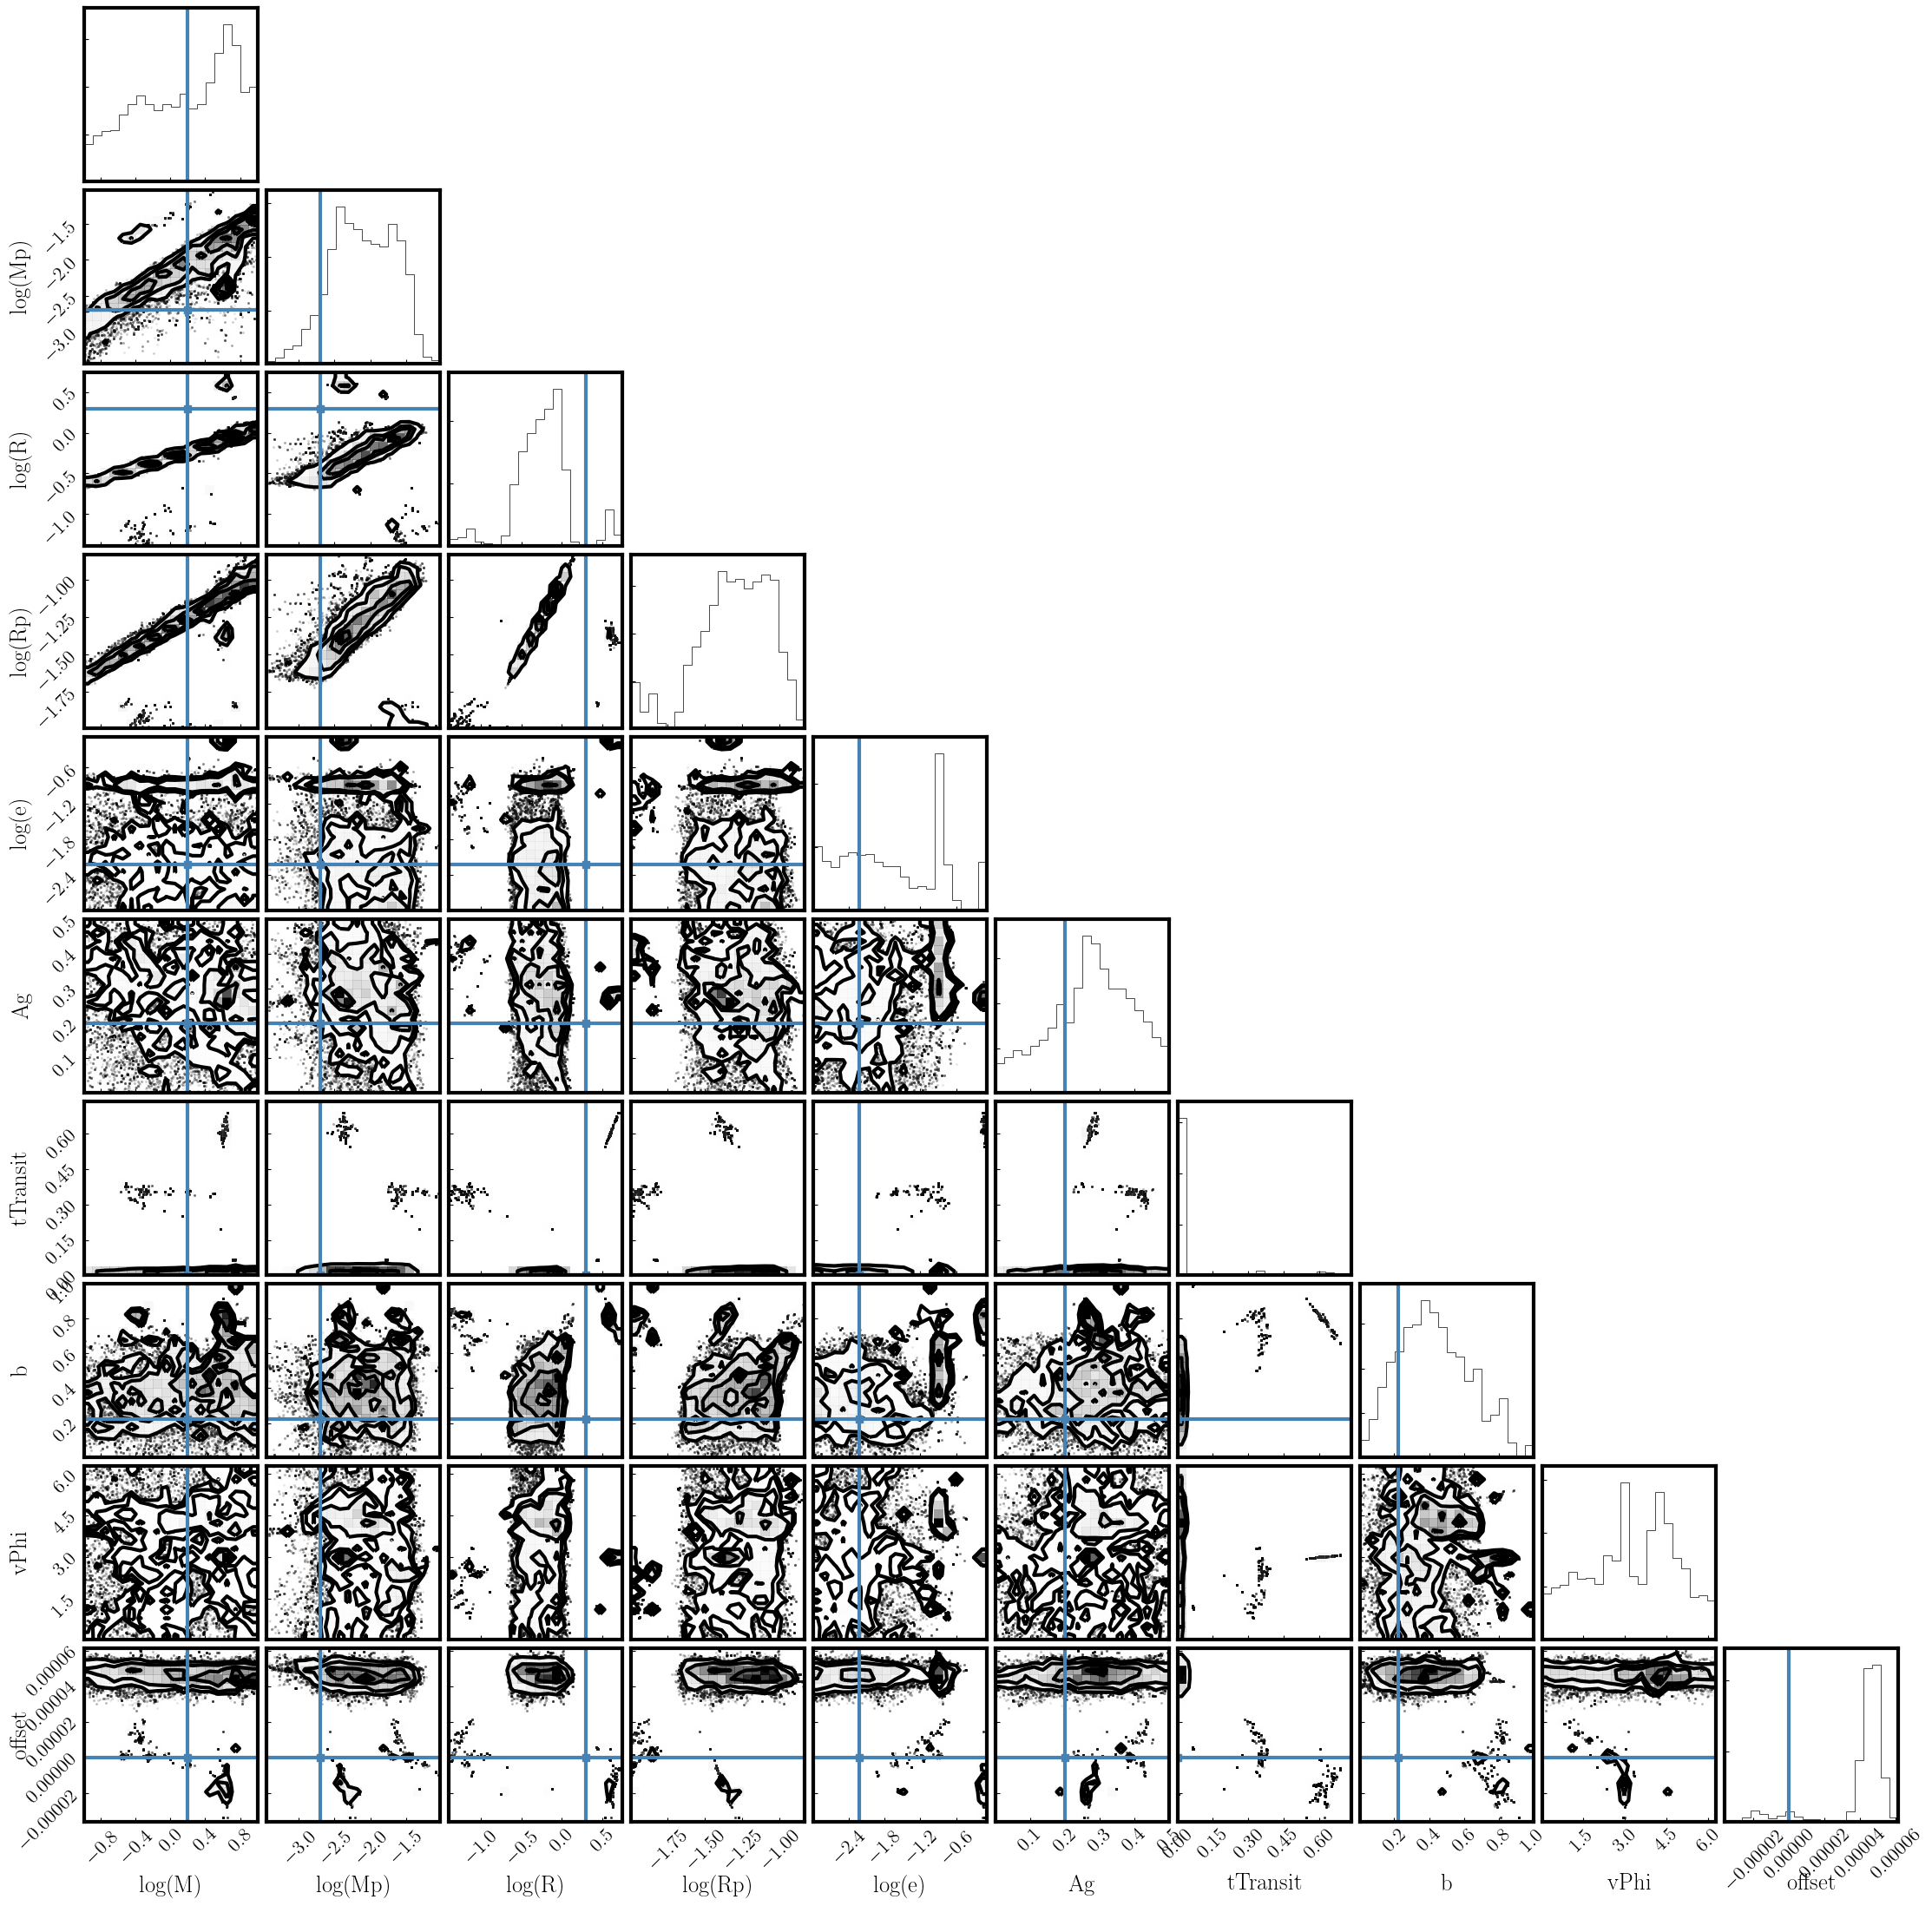

In [19]:
#make corner plot
print(np.shape(sampler.chain))
samples = sampler.chain[:,1500:,:].reshape((-1, ndim))
truths=[np.log10(1.56),np.log10(0.002),np.log10(2.),np.log10(0.155),np.log10(0.006),0.2,0.,0.224,np.pi/2. - (np.pi/180.)*204.,0.]
mapped=mapXs(samples,period)
print(np.shape(mapped))
fig = corner.corner(mapped,labels=['log(M)','log(Mp)','log(R)','log(Rp)','log(e)','Ag','tTransit','b','vPhi','offset'],truths=truths)
plt.show()

[ 5.44940095e-01 -1.83500696e+00 -1.28892421e-01 -1.14421418e+00
 -8.76964552e-01  4.42281732e-01  6.14410562e-04  4.04982265e-01
  4.24370916e+00  3.83036616e-05]


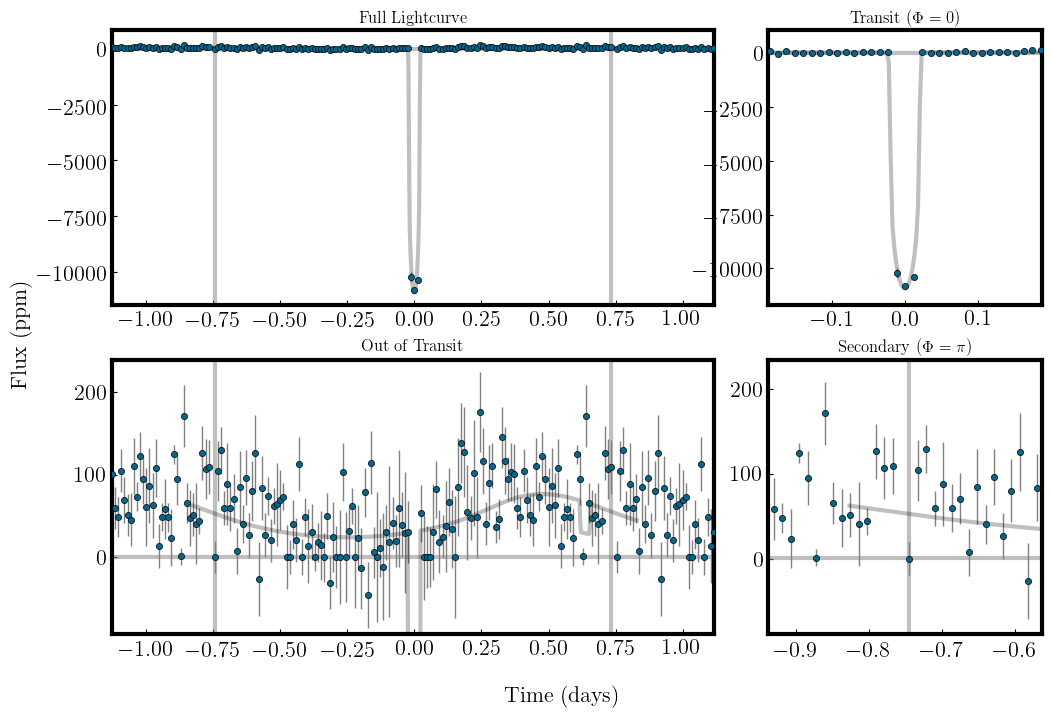

In [20]:
bestX=pos[np.argmax(prob),:]

print(mapXs(bestX, period))

planet=translateParams(planet,mapXs(bestX, period))
planet.a=planet.a*np.power(period/oot.findPeriod(planet),2./3.)

nTs=600
modelTs=np.linspace(-period/2.,period/2.,nTs)
#modelTs=np.hstack([modelTs[:500],modelTs[600:]])
ootFs=1+oot.deltaSum(modelTs,planet)#,secondary=1)

transit=oot.checkTransit(planet)
if transit==1:
    t0,per,rp,a,inc,ecc,w=oot.batman(planet)
    params = batman.TransitParams()
    params.t0 = t0                       #time of inferior conjunction
    params.per = per                      #orbital period
    params.rp = rp                     #planet radius (in units of stellar radii)
    params.a = a                       #semi-major axis (in units of stellar radii)
    params.inc = inc                     #orbital inclination (in degrees)
    params.ecc = ecc                      #eccentricity
    params.w = w                       #longitude of periastron (in degrees)
    params.u = [0.6]                #limb darkening coefficients
    params.limb_dark = "linear"       #limb darkening model

    m = batman.TransitModel(params, modelTs)
    batmanModel=m.light_curve(params)
    modelFs=ootFs*batmanModel
    norm=np.median(modelFs)
    
deltas=(modelFs/norm)-1
deltas=deltas+mapXs(bestX, period)[9]

# plot maximum a posteriori model
thisFig,thisGrid=pyplot.makeFig()
pyplot.plotData(thisGrid,ts,fs,es,period=period)
pyplot.plotModel(thisGrid,modelTs,deltas,period=period)
plt.show()

#### Check chain convergence

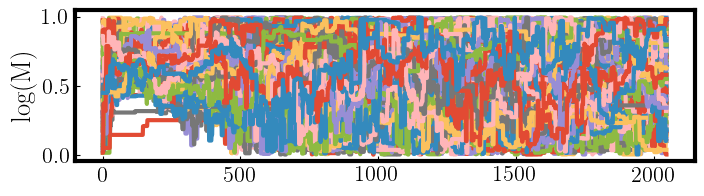

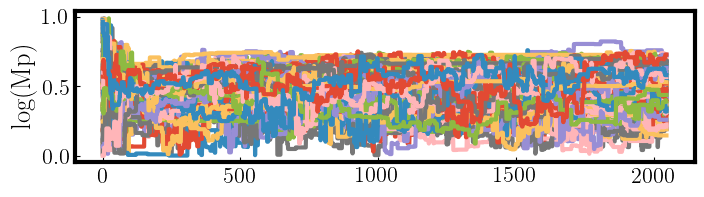

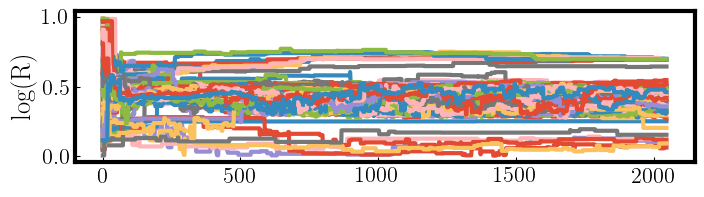

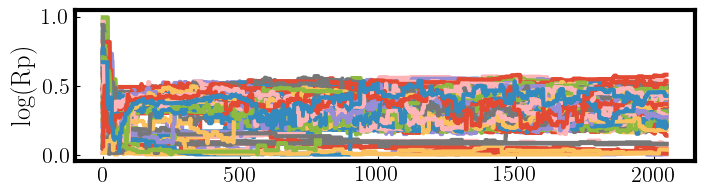

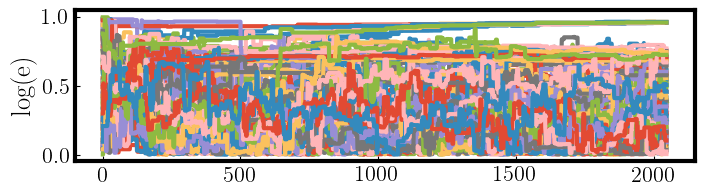

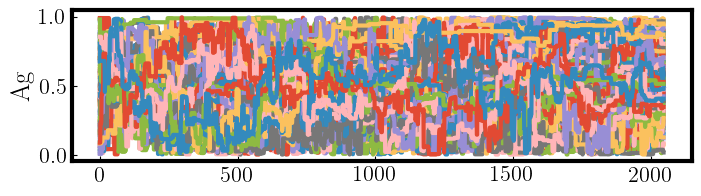

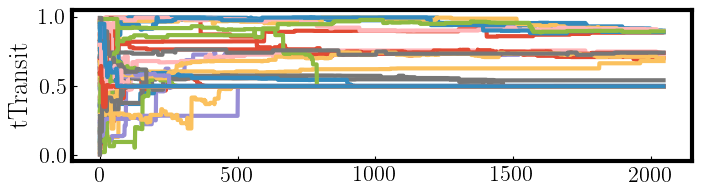

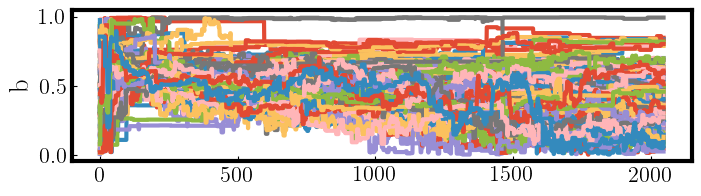

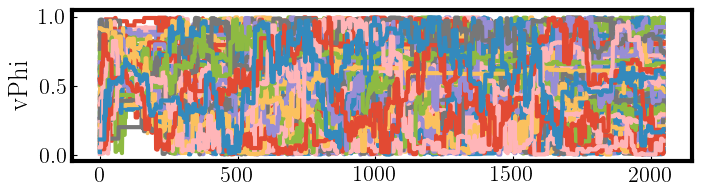

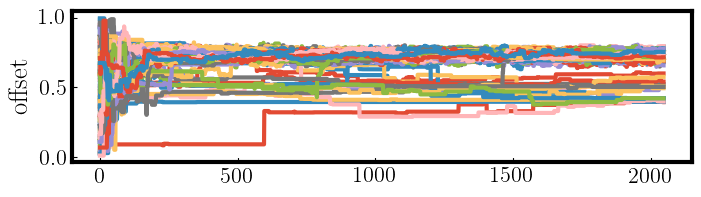

In [21]:
labels=['log(M)','log(Mp)','log(R)','log(Rp)','log(e)','Ag','tTransit','b','vPhi','offset']

for i in range(10):
    fig = plt.figure(figsize=(8,2))
    for j in range(nwalkers):
        plt.plot(sampler.chain[j,:,i])
    
    plt.ylabel(labels[i])
    plt.show()